# **Web scraping of the protiens dataset for uniprot database**

In [ ]:
# @title web scraping response checking
import requests, sys, json

# Documentation: https://www.uniprot.org/help/api
WEBSITE_API = "https://rest.uniprot.org/"

# Documentation: https://www.ebi.ac.uk/proteins/api/doc/
PROTEINS_API = "https://www.ebi.ac.uk/proteins/api"

# Helper function to download data
def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);

  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response

In [ ]:
# @title getting response in tsv asd saving the file in csv fromat
import csv
from io import StringIO  # For handling in-memory text
r = get_url("https://rest.uniprot.org/uniprotkb/stream?compressed=false&fields=accession%2Cprotein_name%2Csequence%2Cmass%2Clength&format=tsv&query=%28human+proteins%29+AND+%28model_organism%3A9606%29")
# r = get_url(f"{WEBSITE_API}/uniprotkb/stream?compressed=true&fields=accession%2Cprotein_name%2Csequence%2Cmass%2Cfeature_count&format=tsv&query=%28proteins%29+AND+%28model_organism%3A9606%29")
# Assuming that 'r' contains TSV data
import csv
from io import StringIO

# Assuming that 'r' contains TSV data
tsv_data = r.text

# Convert TSV data to a list of rows
rows = tsv_data.split('\n')

# Create a CSV file in memory (you can also specify a file path)
csv_buffer = StringIO()
csv_writer = csv.writer(csv_buffer)

# Custom function to process and write TSV data to CSV
def process_and_write_tsv_to_csv(tsv_data):
    rows = tsv_data.strip().split('\n')
    for row in rows:
        columns = row.strip().split('\t')
        csv_writer.writerow(columns)

# Process and write the TSV data to CSV
process_and_write_tsv_to_csv(tsv_data)

# Save the CSV data to a file
with open('df1.csv', 'w', newline='') as csvfile:
    csvfile.write(csv_buffer.getvalue())

print("CSV data has been saved to 'df1.csv'.")

CSV data has been saved to 'df1.csv'.


In [ ]:
# @title Mounting with google drive and saving the created csv in UE PROject folder
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load your CSV into a DataFrame
df = pd.read_csv("/content/df1.csv")

# Create the directory if it doesn't exist
save_path = '/content/drive/MyDrive/UE PRoject'
!mkdir -p "$save_path"

# Save the DataFrame as a new CSV file in the specified directory
df.to_csv(f'{save_path}/df1.csv', index=False)

Mounted at /content/drive


FileNotFoundError: ignored

## **RNN MODEL**

## Installing the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
   import pandas,numpy,sklearn,tensorflow
except:
  ! pip install pandas numpy scikit-learn tensorflow

In [ ]:
# @title Model beta
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, GlobalAveragePooling1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow .keras.optimizers import RMSprop,Adamax
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd

# Load your dataset from a CSV file
# Make sure to specify the correct path to your dataset file
data = pd.read_csv('/content/df1.csv')

# Extract data from the CSV file
protein_names = data['Protein names'].values
protein_sequences = data['Sequence'].values
protein_lengths = data['Length'].values
protein_masses = data['Mass'].values

# Tokenize protein names
name_tokenizer = Tokenizer()
name_tokenizer.fit_on_texts(protein_names)
name_sequences = name_tokenizer.texts_to_sequences(protein_names)
name_sequences = pad_sequences(name_sequences, padding='post')

# Tokenize protein sequences (assuming they are in text format)
sequence_tokenizer = Tokenizer()
sequence_tokenizer.fit_on_texts(protein_sequences)
sequence_sequences = sequence_tokenizer.texts_to_sequences(protein_sequences)
sequence_sequences = pad_sequences(sequence_sequences, padding='post')

# Normalize protein lengths (optional, depending on your dataset)
# protein_lengths = np.array(protein_lengths) / np.max(protein_lengths)

# Define your model
name_input = Input(shape=(name_sequences.shape[1],))
sequence_input = Input(shape=(sequence_sequences.shape[1],))
length_input = Input(shape=(1,))

embedding_dim =128  # Adjust as needed
lstm_units = 512# Adjust as needed
dropout_rate=0.0000001
l2_reg=0.00009
name_embedding = Embedding(input_dim=len(name_tokenizer.word_index) + 1, output_dim=embedding_dim)(name_input)
sequence_embedding = Embedding(input_dim=len(sequence_tokenizer.word_index) + 1, output_dim=embedding_dim)(sequence_input)

# Apply Global Average Pooling (GAP) to reduce dimensions
name_embedding = GlobalAveragePooling1D()(name_embedding)
sequence_embedding = GlobalAveragePooling1D()(sequence_embedding)

combined_input = Concatenate()([name_embedding, sequence_embedding, length_input])

# Reshape the input to 3D for LSTM
combined_input = tf.keras.layers.Reshape((1, -1))(combined_input)

# Add LSTM layers
lstm_layer1 = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg))(combined_input)
# dropout_layer1 = Dropout(rate=dropout_rate)(lstm_layer1)

# Add more LSTM and dropout layers
lstm_layer2 = LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg))(lstm_layer1)
dropout_layer2 = Dropout(rate=dropout_rate)(lstm_layer2)

# lstm_layer3 = LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg))(dropout_layer2)
# dropout_layer3 = Dropout(rate=dropout_rate)(lstm_layer3)

output = Dense(1)(lstm_layer2)  # Regression output

model = Model(inputs=[name_input, sequence_input, length_input], outputs=output)
optimizer = Adamax(learning_rate=10)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
# model.summary()
# Train the model
model.fit([name_sequences, sequence_sequences, protein_lengths], protein_masses, epochs=50, validation_split=0.2,batch_size=5063)

# Make predictions
predictions = model.predict([name_sequences, sequence_sequences, protein_lengths])
print(np.mean(predictions))

In [2]:
# @title Model Alpha
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax,Adam,Adagrad
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# Load your dataset from a CSV file
# Make sure to specify the correct path to your dataset file
data = pd.read_csv('/content/drive/MyDrive/UE PRoject/df1.csv')

# Extract data from the CSV file
protein_names = data['Protein names'].values
protein_sequences = data['Sequence'].values
protein_lengths = data['Length'].values
protein_masses = data['Mass'].values

# Tokenize protein names
name_tokenizer = Tokenizer()
name_tokenizer.fit_on_texts(protein_names)
name_sequences = name_tokenizer.texts_to_sequences(protein_names)
name_sequences = pad_sequences(name_sequences, padding='post')

# Tokenize protein sequences (assuming they are in text format)
sequence_tokenizer = Tokenizer()
sequence_tokenizer.fit_on_texts(protein_sequences)
sequence_sequences = sequence_tokenizer.texts_to_sequences(protein_sequences)
sequence_sequences = pad_sequences(sequence_sequences, padding='post')

# Split the data into training and validation sets (80% train, 20% validation)
name_train, name_val, sequence_train, sequence_val, length_train, length_val, mass_train, mass_val = train_test_split(
    name_sequences, sequence_sequences, protein_lengths, protein_masses, test_size=0.2, random_state=42
)

# Define your model
name_input = Input(shape=(name_sequences.shape[1],))
sequence_input = Input(shape=(sequence_sequences.shape[1],))
length_input = Input(shape=(1,))

embedding_dim = 254  # Adjust as needed
lstm_units = 1024 # Adjust as needed
dropout_rate = 0.0000001
l2_reg = 0.000009
name_embedding = Embedding(input_dim=len(name_tokenizer.word_index) + 1, output_dim=embedding_dim)(name_input)
sequence_embedding = Embedding(input_dim=len(sequence_tokenizer.word_index) + 1, output_dim=embedding_dim)(sequence_input)

# Apply Global Average Pooling (GAP) to reduce dimensions
name_embedding = GlobalAveragePooling1D()(name_embedding)
sequence_embedding = GlobalAveragePooling1D()(sequence_embedding)

combined_input = Concatenate()([name_embedding, sequence_embedding, length_input])

# Reshape the input to 3D for LSTM
combined_input = tf.keras.layers.Reshape((1, -1))(combined_input)

# Add LSTM layers
lstm_layer1 = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg),activation="tanh")(combined_input)

# Add more LSTM and dropout layers
lstm_layer2 = LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg),activation="tanh")(lstm_layer1)
dropout_layer2 = Dropout(rate=dropout_rate)(lstm_layer2)

output = Dense(1,activation="relu")(lstm_layer2)  # Regression output

model = Model(inputs=[name_input, sequence_input, length_input], outputs=output)
optimizer = RMSprop(learning_rate=1)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Train the model on the training data
model.fit([name_train, sequence_train, length_train], mass_train, epochs=50, batch_size=1024, validation_data=([name_val, sequence_val, length_val], mass_val))

Epoch 1/50
16/16 [==============================] - 54s 3s/step - loss: 35123.4844 - val_loss: 31401.4336
Epoch 2/50
16/16 [==============================] - 51s 3s/step - loss: 33897.2773 - val_loss: 32470.6426
Epoch 3/50
16/16 [==============================] - 48s 3s/step - loss: 33280.6758 - val_loss: 31928.4609
Epoch 4/50
16/16 [==============================] - 47s 3s/step - loss: 32885.2383 - val_loss: 31481.0176
Epoch 5/50
16/16 [==============================] - 47s 3s/step - loss: 32618.3574 - val_loss: 31274.2656
Epoch 6/50
16/16 [==============================] - 49s 3s/step - loss: 32297.7207 - val_loss: 30915.3477
Epoch 7/50
16/16 [==============================] - 48s 3s/step - loss: 31959.1602 - val_loss: 30648.0664
Epoch 8/50
16/16 [==============================] - 55s 3s/step - loss: 31929.1777 - val_loss: 31336.1230
Epoch 9/50
16/16 [==============================] - 52s 3s/step - loss: 31917.3203 - val_loss: 30770.5898
Epoch 10/50
16/16 [===========================

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 484)]                0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 484, 254)             4810252   ['input_4[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 254)               5005832   ['input_5[0][0]']             
                                                                                            

In [4]:
model.save("/content/drive/MyDrive/UE PRoject/my_model")

In [5]:
# Assuming you have already defined and trained your model
# Evaluate the model on the training data
# evaluation_result = model.predict([name_train, sequence_train, length_train])


# Make predictions on the validation data
predictions = model.predict([name_val, sequence_val, length_val])

# Calculate the mean of predicted mass and test mass
mean_of_predicted_mass = np.mean(predictions)
# mean_of_evaulated_mass=np.mean(evaluation_result)
mean_of_test_mass = np.mean(mass_val)
# mean_of_train_mass = np.mean(mass_train)
# Calculate the accuracy as a percentage
pa = (mean_of_predicted_mass / mean_of_test_mass) * 100
# aa=  (mean_of_evaulated_mass / mean_of_train_mass) * 100
# Print the model summary

# Print the activation function, optimizer, learning rate, epochs, and batch size
a = [ "Optimizer:-","Activation_function:-", "Learning_rate:", "Epochs:-", "Batch_size:-"]
b = ["RMSprop", "relu", "1", "50", "1024"]

for i, j in zip(a, b):
    print(i, j, sep="->")

# Print the accuracy on the training and test data
# print("Accuracy_on_train_data:",aa)
print("Accuracy_on_test_data:", pa)

127/127 [==============================] - 11s 79ms/step
Optimizer:-->RMSprop
Activation_function:-->relu
Learning_rate:->1
Epochs:-->50
Batch_size:-->1024
Accuracy_on_test_data: 76.05812271356423


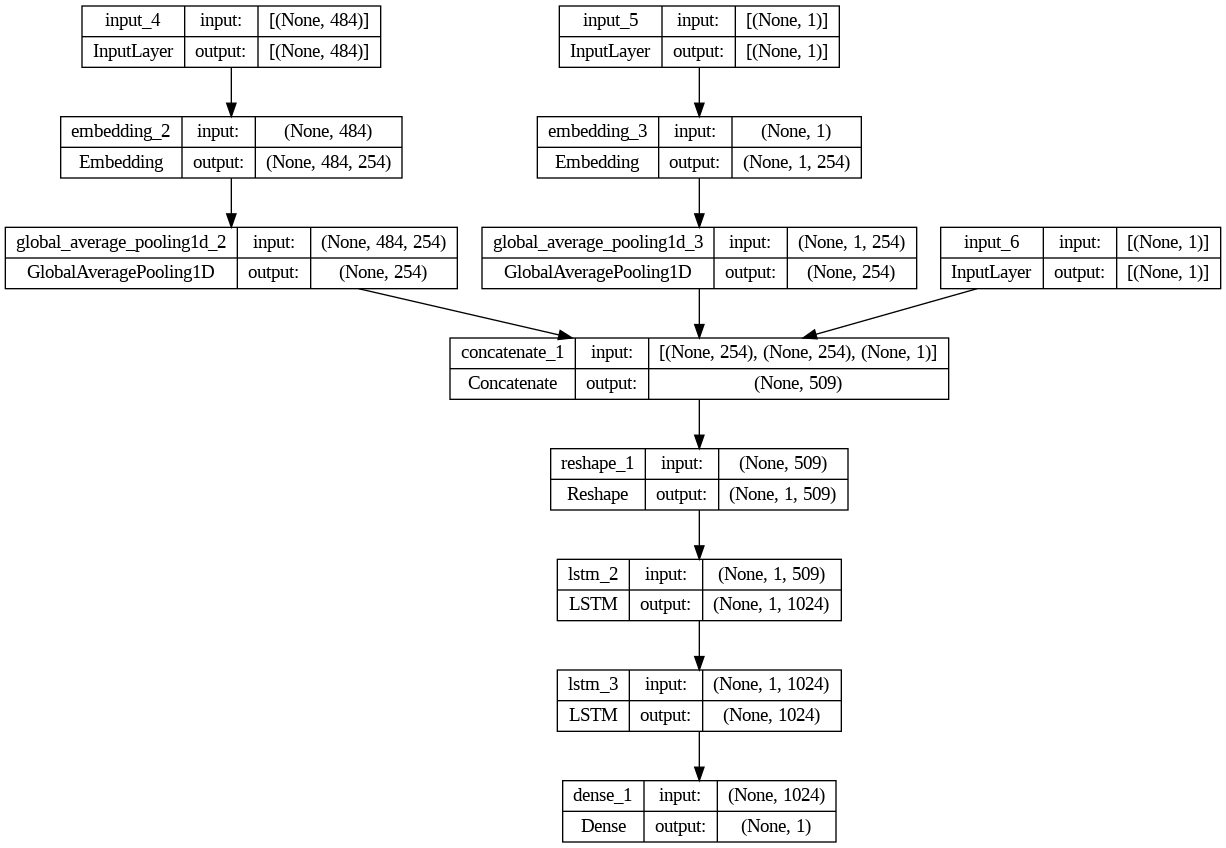

In [6]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Load the pre-trained model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/UE PRoject/my_model")

# Specify the file path where the visualization will be saved (optional)
visualization_path = "/content/drive/MyDrive/UE PRoject/model_visualization.png"

# Generate and display the model architecture visualization
plot_model(loaded_model, to_file=visualization_path, show_shapes=True, show_layer_names=True)

# If you want to display the visualization directly in the Colab notebook:
from IPython.display import Image
Image(visualization_path)


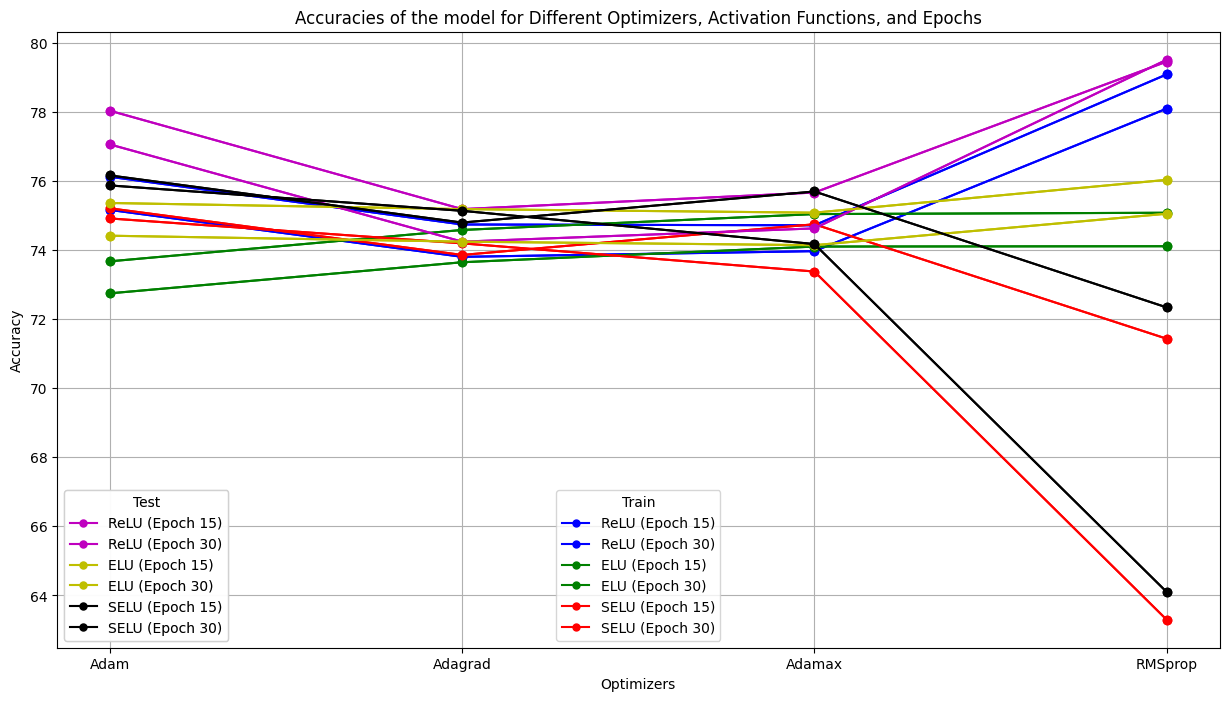

In [7]:
# @title Graph
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerTuple

# Data (same as in your code)
# Data
optimizers = ['Adam', 'Adagrad', 'Adamax', 'RMSprop']
activation_functions = ['ReLU', 'ELU', 'SELU']
epochs = ['15', '30']
settt=['Train', 'Test']
# Updated accuracy data for training and testing
accuracy_values = {
    'Adam': {
        'ReLU': {
            'Train': [75.1591, 76.1181],
            'Test': [77.0549, 78.0305],
        },
        'ELU': {
            'Train': [72.7445, 73.6712],
            'Test': [74.4127, 75.3601],
        },
        'SELU': {
            'Train': [75.2061, 74.9123],
            'Test': [76.1583, 75.8678],
        }
    },
    'Adagrad': {
        'ReLU': {
            'Train': [73.8011, 74.7375],
            'Test': [74.2407, 75.1827],
        },
        'ELU': {
            'Train': [73.6446, 74.5791],
            'Test': [74.2407, 75.1827],
        },
        'SELU': {
            'Train': [73.8558, 74.1917],
            'Test': [74.7929, 75.1331],
        }
    },
    'Adamax': {
        'ReLU': {
            'Train': [73.9659, 74.7140],
            'Test': [74.6243, 75.6620],
        },
        'ELU': {
            'Train': [74.0986, 75.0388],
            'Test': [74.1387, 75.0794],
        },
        'SELU': {
            'Train': [74.7442, 73.3758],
            'Test': [75.6925, 74.1712],
        }
    },
    'RMSprop': {
        'ReLU': {
            'Train': [78.0913, 79.0821],
            'Test': [79.5067, 79.4521],
        },
        'ELU': {
            'Train': [74.1081, 75.0770],
            'Test': [75.0485, 76.0296],
        },
        'SELU': {
            'Train': [71.4310, 63.2973],
            'Test': [72.3374, 64.1005],
        }
    }
}
# Define colors for the lines for Train and Test
train_colors = ['b', 'g', 'r', 'c','violet','purple']  # You can add more colors as needed
test_colors = ['m', 'y', 'k']

# Function to create a line plot for a given data type, activation function, and epoch
def create_line_plot(data_type, activation, epoch):
    x = np.arange(len(optimizers))
    values = [accuracy_values[optimizer][activation][data_type] for optimizer in optimizers]
    label = f'{activation} ({data_type} - Epoch {epoch})'
    color = train_colors if data_type == 'Train' else test_colors
    plt.plot(x, values, marker='o', label=label, color=color[activation_functions.index(activation)])

# Create and display line plots in one graph for Train and Test accuracy
plt.figure(figsize=(15, 8))
x = np.arange(len(optimizers))
plt.xticks(x, optimizers)  # Set custom x-ticks

train_legend_handles = []  # Collect legend handles for Train
test_legend_handles = []   # Collect legend handles for Test

for data_type in settt:
    for activation in activation_functions:
        for epoch in epochs:
            create_line_plot(data_type, activation, epoch)
            label = f'{activation} (Epoch {epoch})'
            if data_type == 'Train':
                train_legend_handles.append(plt.Line2D([], [], marker='o', markersize=5, label=label, color=train_colors[activation_functions.index(activation)]))
            else:
                test_legend_handles.append(plt.Line2D([], [], marker='o', markersize=5, label=label, color=test_colors[activation_functions.index(activation)]))

plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.title('Accuracies of the model for Different Optimizers, Activation Functions, and Epochs')

# Create separate legends for Train and Test
train_legend = plt.legend(handles=train_legend_handles, loc='lower center', title='Train')
test_legend = plt.legend(handles=test_legend_handles, loc='lower left', title='Test')

# Combine the legends into a single legend
plt.gca().add_artist(train_legend)
plt.gca().add_artist(test_legend)

plt.grid(True)
plt.show()